In [94]:
 # numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder,RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold , cross_val_score
from sklearn.linear_model import Ridge ,RidgeClassifier, RidgeClassifierCV
from sklearn.metrics import accuracy_score ,roc_auc_score ,classification_report
# File system management
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py

from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import optuna
from optuna.samplers import TPESampler



In [23]:
app_train = pd.read_csv("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_train.csv")
app_test = pd.read_csv("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_test.csv")
POS_CASH = pd.read_csv('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/POS_CASH_balance.csv')
credit_card = pd.read_csv('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/credit_card_balance.csv')
bureau = pd.read_csv('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/bureau.csv')
previous_app = pd.read_csv('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/previous_application.csv')
subm = pd.read_csv("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/sample_submission.csv")

#Convert to parquet
app_train.to_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_train.parquet", index=False)
app_test.to_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_test.parquet", index=False)
POS_CASH.to_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/POS_CASH_balance.parquet', index=False)
credit_card.to_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/credit_card_balance.parquet', index=False)
bureau.to_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/bureau.parquet', index=False)
previous_app.to_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/previous_application.parquet', index=False)
subm.to_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/sample_submission.parquet", index=False) 

#Read Parquet files
app_train_parquet = pd.read_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_train.parquet")
app_test_parquet = pd.read_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/application_test.parquet")
POS_CASH_parquet = pd.read_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/POS_CASH_balance.parquet')
credit_card_parquet = pd.read_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/credit_card_balance.parquet')
bureau_parquet = pd.read_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/bureau.parquet')
previous_app_parquet = pd.read_parquet('/srv/scratch/beyza/Home-Credit-Default-Risk/Data/previous_application.parquet')
subm_parquet = pd.read_parquet("/srv/scratch/beyza/Home-Credit-Default-Risk/Data/sample_submission.parquet")


#### Merge Datasets with only numeric

In [24]:
def groupby_mean(df, group_column):
    return df.groupby(group_column).mean(numeric_only=True).reset_index()

data_train = app_train_parquet.merge(groupby_mean(POS_CASH_parquet, 'SK_ID_CURR'),
                             how='left', on='SK_ID_CURR')
data_test = app_test_parquet.merge(groupby_mean(POS_CASH_parquet, 'SK_ID_CURR'),
                            how='left', on='SK_ID_CURR')

data_train = data_train.merge(groupby_mean(credit_card_parquet, 'SK_ID_CURR'),
                              how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean(credit_card_parquet, 'SK_ID_CURR'),
                             how='left', on='SK_ID_CURR')

data_train = data_train.merge(groupby_mean(bureau_parquet, 'SK_ID_CURR'),
                              how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean(bureau_parquet, 'SK_ID_CURR'),
                             how='left', on='SK_ID_CURR')

data_train = data_train.merge(groupby_mean(previous_app_parquet, 'SK_ID_CURR'),
                              how='left', on='SK_ID_CURR')
data_test = data_test.merge(groupby_mean(previous_app_parquet, 'SK_ID_CURR'),
                             how='left', on='SK_ID_CURR')

### Preprocessing

In [25]:
target_train = data_train['TARGET']
data_train.drop(['SK_ID_CURR', 'TARGET','FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)
data_test.drop(['SK_ID_CURR','FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)

#Delete unnecesarry features
data_train.drop(['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)
data_test.drop(['FLAG_MOBIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12'], axis=1, inplace=True)


#### Handle Missing Values

In [26]:
categorical_features = [col for col in data_train.columns if data_train[col].dtype == 'object']
data_train[categorical_features] = data_train[categorical_features].fillna('missing')
data_test[categorical_features] = data_test[categorical_features].fillna('missing')

In [27]:
categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [28]:
numeric_features = [col for col in data_train.columns if col not in categorical_features]
data_train[numeric_features] = data_train[numeric_features].fillna(data_train[numeric_features].mean())
data_test[numeric_features] = data_test[numeric_features].fillna(data_train[numeric_features].mean())

In [29]:
numeric_features

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATI

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train, target_train, test_size=0.2)

#### One-hot-encoding

In [42]:
# Apply one-hot encoding to categorical features
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats_train = one_hot_encoder.fit_transform(X_train[categorical_features])
encoded_cats_valid = one_hot_encoder.transform(X_valid[categorical_features])

# Convert encoded categories back to a DataFrame with appropriate column names
encoded_cats_train_df = pd.DataFrame(encoded_cats_train, columns=one_hot_encoder.get_feature_names_out(categorical_features))
encoded_cats_valid_df = pd.DataFrame(encoded_cats_valid, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Reset index to align with the original data
encoded_cats_train_df.index = X_train.index
encoded_cats_valid_df.index = X_valid.index

# Drop original categorical features and add encoded ones
X_train_encoded = pd.concat([X_train.drop(columns=categorical_features), encoded_cats_train_df], axis=1)
X_valid_encoded = pd.concat([X_valid.drop(columns=categorical_features), encoded_cats_valid_df], axis=1)


### Model Evaluation

In [43]:
skf = StratifiedKFold(n_splits=3)

In [44]:
for train_index, valid_index in skf.split(X_train_encoded, y_train):
    X_train_cv, X_valid_cv = X_train_encoded.iloc[train_index], X_train_encoded.iloc[valid_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[valid_index]
    

In [47]:
alphas = [0.1, 1.0, 10.0]  # Test etmek istediğiniz alpha değerleri
model = RidgeClassifierCV(alphas=alphas, cv=StratifiedKFold(n_splits=3))

ridge_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=skf, scoring='roc_auc')

print("RidgeClassifierCV Ortalama ROC-AUC Skoru: ", np.mean(ridge_scores))


RidgeClassifierCV Ortalama ROC-AUC Skoru:  0.7506824712794722


In [50]:
lofo_dataset = pd.concat([X_train_encoded, y_train.reset_index(drop=True)], axis=1)
print(lofo_dataset.isna().sum())

lofo_dataset.columns = list(X_train_encoded.columns) + ['TARGET']
print(lofo_dataset['TARGET'].isna().sum()) 


CNT_CHILDREN                   49163
AMT_INCOME_TOTAL               49163
AMT_CREDIT_x                   49163
AMT_ANNUITY_x                  49163
AMT_GOODS_PRICE_x              49163
                               ...  
WALLSMATERIAL_MODE_Wooden      49163
WALLSMATERIAL_MODE_missing     49163
EMERGENCYSTATE_MODE_Yes        49163
EMERGENCYSTATE_MODE_missing    49163
TARGET                         49163
Length: 290, dtype: int64
49163


In [51]:
# Drop rows with missing TARGET values
lofo_dataset_cleaned = lofo_dataset.dropna(subset=['TARGET']).copy()

# Handle missing values in features by imputing (filling) them with column means
lofo_dataset_cleaned.fillna(lofo_dataset_cleaned.mean(), inplace=True)

# Verify that there are no missing values left
print(lofo_dataset_cleaned.isna().sum())

CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT_x                   0
AMT_ANNUITY_x                  0
AMT_GOODS_PRICE_x              0
                              ..
WALLSMATERIAL_MODE_Wooden      0
WALLSMATERIAL_MODE_missing     0
EMERGENCYSTATE_MODE_Yes        0
EMERGENCYSTATE_MODE_missing    0
TARGET                         0
Length: 290, dtype: int64


In [67]:
sample_size = int(0.01 * len(lofo_dataset_cleaned))  # use %1 sample 
lofo_dataset_sample = lofo_dataset_cleaned.sample(n=sample_size, random_state=42)

dataset = Dataset(df=lofo_dataset_sample, target="TARGET", features=list(X_train_encoded.columns))

# Initialize LOFOImportance
lofo_imp = LOFOImportance(dataset, model=model, scoring="roc_auc", cv=skf)

# Get importance values
importance_df = lofo_imp.get_importance()

# Display the results
print(importance_df)

  0%|          | 0/289 [00:00<?, ?it/s]

                                      feature  importance_mean  \
79                   DEF_60_CNT_SOCIAL_CIRCLE         0.006032   
114       FONDKAPREMONT_MODE_reg oper account         0.005424   
33                EMERGENCYSTATE_MODE_missing         0.004768   
19                  WALLSMATERIAL_MODE_Wooden         0.004612   
0          WEEKDAY_APPR_PROCESS_START_TUESDAY         0.003575   
..                                        ...              ...   
226  ORGANIZATION_TYPE_Business Entity Type 3        -0.005440   
210                            FLAG_OWN_CAR_Y        -0.005792   
46                     AMT_CREDIT_SUM_OVERDUE        -0.006306   
77                          AMT_GOODS_PRICE_x        -0.007301   
160                         DAYS_ENDDATE_FACT        -0.009815   

     importance_std  val_imp_0  val_imp_1  val_imp_2  
79         0.000437   0.006643   0.005807   0.005647  
114        0.001227   0.004829   0.007134   0.004310  
33         0.000786   0.005502   0.005124 

In [68]:
importance_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2
79,DEF_60_CNT_SOCIAL_CIRCLE,0.006032,0.000437,0.006643,0.005807,0.005647
114,FONDKAPREMONT_MODE_reg oper account,0.005424,0.001227,0.004829,0.007134,0.004310
33,EMERGENCYSTATE_MODE_missing,0.004768,0.000786,0.005502,0.005124,0.003677
19,WALLSMATERIAL_MODE_Wooden,0.004612,0.001556,0.005094,0.006229,0.002512
0,WEEKDAY_APPR_PROCESS_START_TUESDAY,0.003575,0.001521,0.005339,0.003758,0.001628
...,...,...,...,...,...,...
226,ORGANIZATION_TYPE_Business Entity Type 3,-0.005440,0.004772,-0.005298,-0.011354,0.000332
210,FLAG_OWN_CAR_Y,-0.005792,0.004814,-0.011248,-0.006591,0.000462
46,AMT_CREDIT_SUM_OVERDUE,-0.006306,0.008812,-0.018767,-0.000161,0.000010
77,AMT_GOODS_PRICE_x,-0.007301,0.007650,-0.003546,-0.017965,-0.000392


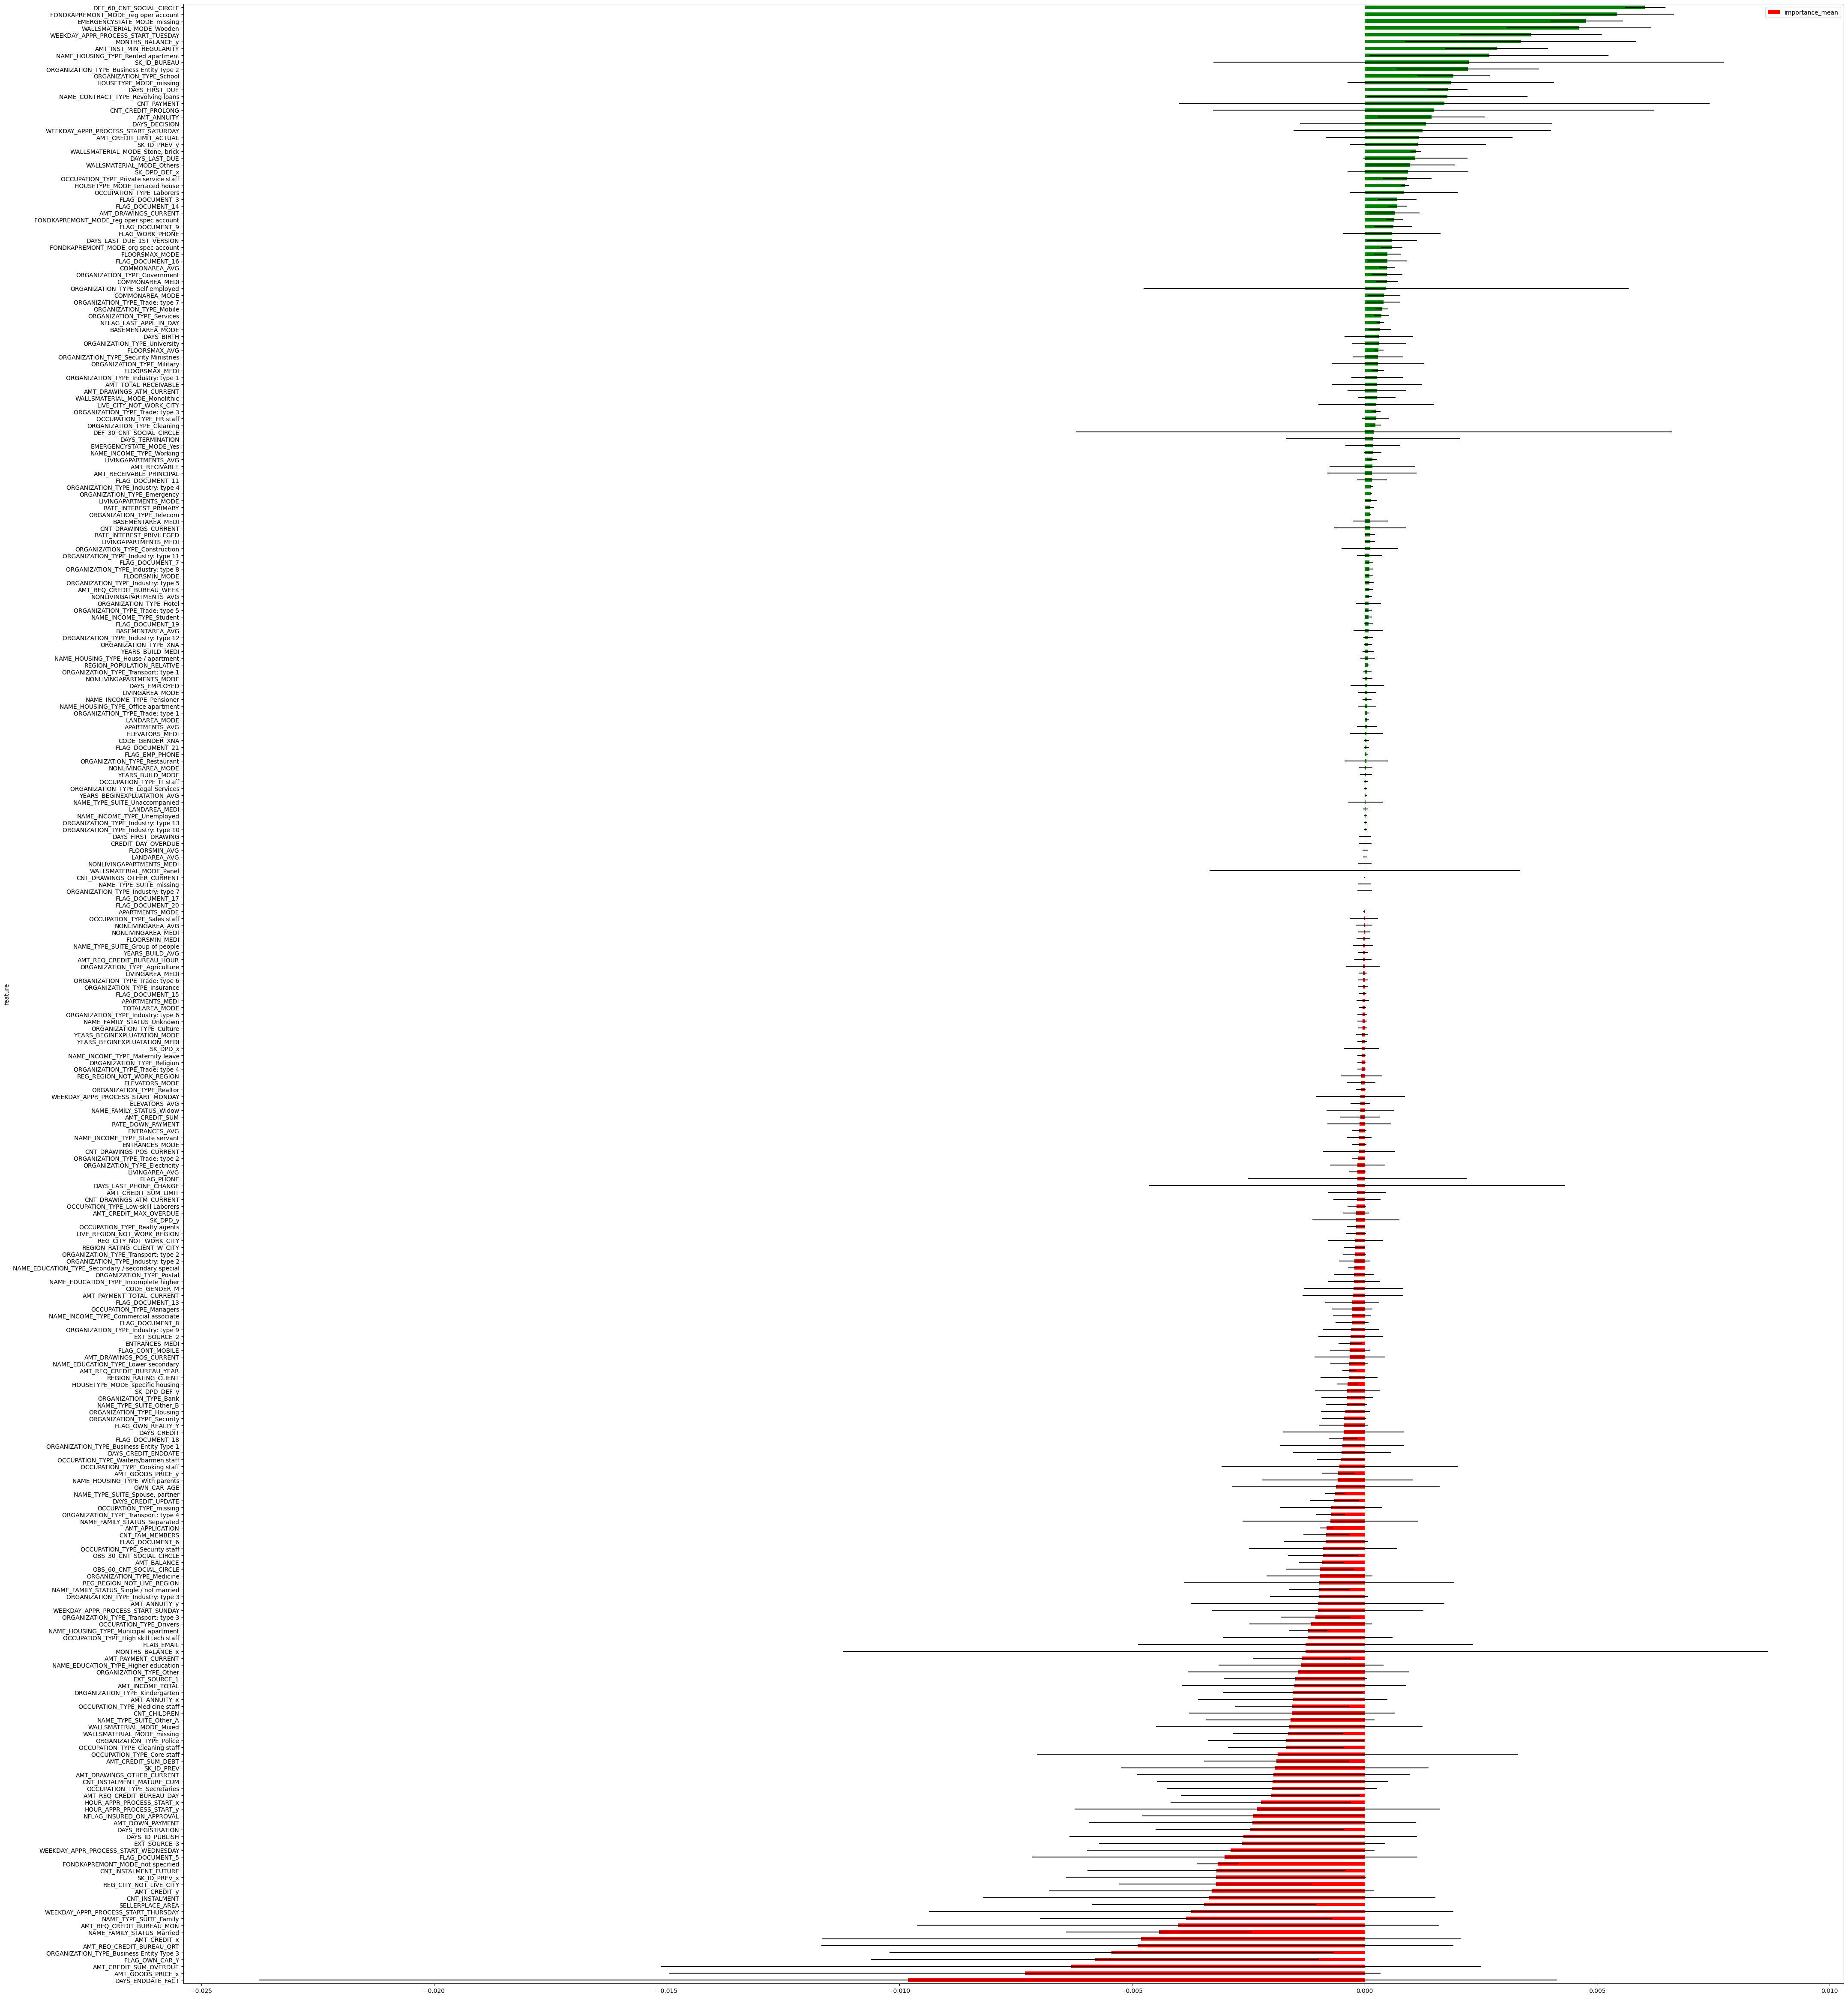

In [69]:
# Plot the results
plot_importance(importance_df, figsize=(50, 60))

In [64]:
important_features = importance_df[importance_df['importance_mean'] > 0.001]['feature'].tolist()
print(len(important_features))

184


In [70]:
important_features

['AMT_GOODS_PRICE_y',
 'AMT_CREDIT_y',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_DOWN_PAYMENT',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_PHONE',
 'AMT_ANNUITY_x',
 'DAYS_LAST_DUE_1ST_VERSION',
 'CNT_INSTALMENT',
 'ORGANIZATION_TYPE_Business Entity Type 2',
 'AMT_APPLICATION',
 'DAYS_REGISTRATION',
 'SK_ID_BUREAU',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_PAYMENT_CURRENT',
 'AMT_CREDIT_SUM_DEBT',
 'SK_ID_PREV_x',
 'AMT_DRAWINGS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_PREV',
 'DAYS_ENDDATE_FACT',
 'DAYS_BIRTH',
 'NAME_HOUSING_TYPE_House / apartment',
 'DAYS_DECISION',
 'FLAG_DOCUMENT_6',
 'ORGANIZATION_TYPE_Construction',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'EXT_SOURCE_3',
 'FLAG_OWN_REALTY_Y',
 'ORGANIZATION_TYPE_Postal',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'REGION_RATING_CLIENT_W_CITY',
 'OCCUPATION_TYPE_Core staff',
 'AMT_GOODS_PRICE_x',
 'NAME_FAMILY_STATUS_Widow',
 'EXT_SOURCE_2',
 'ORGANIZA


Save importance features

In [71]:
importance_features=['AMT_GOODS_PRICE_y',
 'AMT_CREDIT_y',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_DOWN_PAYMENT',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_PHONE',
 'AMT_ANNUITY_x',
 'DAYS_LAST_DUE_1ST_VERSION',
 'CNT_INSTALMENT',
 'ORGANIZATION_TYPE_Business Entity Type 2',
 'AMT_APPLICATION',
 'DAYS_REGISTRATION',
 'SK_ID_BUREAU',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_PAYMENT_CURRENT',
 'AMT_CREDIT_SUM_DEBT',
 'SK_ID_PREV_x',
 'AMT_DRAWINGS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_CREDIT_SUM_OVERDUE',
 'SK_ID_PREV',
 'DAYS_ENDDATE_FACT',
 'DAYS_BIRTH',
 'NAME_HOUSING_TYPE_House / apartment',
 'DAYS_DECISION',
 'FLAG_DOCUMENT_6',
 'ORGANIZATION_TYPE_Construction',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'EXT_SOURCE_3',
 'FLAG_OWN_REALTY_Y',
 'ORGANIZATION_TYPE_Postal',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'REGION_RATING_CLIENT_W_CITY',
 'OCCUPATION_TYPE_Core staff',
 'AMT_GOODS_PRICE_x',
 'NAME_FAMILY_STATUS_Widow',
 'EXT_SOURCE_2',
 'ORGANIZATION_TYPE_School',
 'EMERGENCYSTATE_MODE_missing',
 'ORGANIZATION_TYPE_Industry: type 3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE_Security Ministries',
 'RATE_DOWN_PAYMENT',
 'ORGANIZATION_TYPE_Industry: type 4',
 'BASEMENTAREA_MEDI',
 'ORGANIZATION_TYPE_Industry: type 5',
 'ORGANIZATION_TYPE_Emergency',
 'DAYS_ID_PUBLISH',
 'SK_DPD_DEF_y',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'ORGANIZATION_TYPE_Culture',
 'FLAG_DOCUMENT_13',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'OCCUPATION_TYPE_Waiters/barmen staff',
 'OCCUPATION_TYPE_Secretaries',
 'NAME_HOUSING_TYPE_Office apartment',
 'RATE_INTEREST_PRIVILEGED',
 'EMERGENCYSTATE_MODE_Yes',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_Realty agents',
 'ORGANIZATION_TYPE_Industry: type 9',
 'ORGANIZATION_TYPE_Religion',
 'ORGANIZATION_TYPE_Industry: type 13',
 'ORGANIZATION_TYPE_Business Entity Type 1',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_TYPE_SUITE_Group of people',
 'ORGANIZATION_TYPE_Industry: type 7',
 'REGION_RATING_CLIENT',
 'ORGANIZATION_TYPE_Housing',
 'LANDAREA_MODE',
 'ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Industry: type 12',
 'ORGANIZATION_TYPE_Military',
 'ORGANIZATION_TYPE_Security',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'FLAG_EMP_PHONE',
 'COMMONAREA_MODE',
 'FLAG_DOCUMENT_9',
 'NONLIVINGAPARTMENTS_AVG',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'WALLSMATERIAL_MODE_Panel',
 'OCCUPATION_TYPE_Private service staff',
 'OCCUPATION_TYPE_Medicine staff',
 'NONLIVINGAREA_MEDI',
 'LANDAREA_AVG',
 'FLOORSMAX_MEDI',
 'ORGANIZATION_TYPE_Industry: type 11',
 'ORGANIZATION_TYPE_Trade: type 1',
 'ORGANIZATION_TYPE_University',
 'ORGANIZATION_TYPE_Trade: type 6',
 'ORGANIZATION_TYPE_XNA',
 'LANDAREA_MEDI',
 'FLAG_DOCUMENT_11',
 'ORGANIZATION_TYPE_Realtor',
 'OCCUPATION_TYPE_Managers',
 'ORGANIZATION_TYPE_Police',
 'HOUSETYPE_MODE_terraced house',
 'REG_REGION_NOT_WORK_REGION',
 'WALLSMATERIAL_MODE_Stone, brick',
 'ENTRANCES_AVG',
 'DAYS_EMPLOYED',
 'FLAG_DOCUMENT_8',
 'ELEVATORS_MEDI',
 'RATE_INTEREST_PRIMARY',
 'CNT_DRAWINGS_CURRENT',
 'ELEVATORS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'ORGANIZATION_TYPE_Services',
 'FLAG_DOCUMENT_15',
 'NAME_TYPE_SUITE_Spouse, partner',
 'FLAG_DOCUMENT_18',
 'CREDIT_DAY_OVERDUE',
 'HOUSETYPE_MODE_missing',
 'LIVINGAREA_AVG',
 'FLOORSMIN_AVG',
 'ORGANIZATION_TYPE_Industry: type 1',
 'FLOORSMAX_MODE',
 'NAME_TYPE_SUITE_Other_A',
 'CNT_FAM_MEMBERS',
 'ORGANIZATION_TYPE_Kindergarten',
 'EXT_SOURCE_1',
 'NAME_INCOME_TYPE_Working',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_HOUSING_TYPE_Rented apartment',
 'ORGANIZATION_TYPE_Trade: type 2',
 'ORGANIZATION_TYPE_Medicine',
 'REG_CITY_NOT_LIVE_CITY',
 'WALLSMATERIAL_MODE_Wooden',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'NAME_HOUSING_TYPE_With parents',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'ORGANIZATION_TYPE_Government',
 'NAME_TYPE_SUITE_Unaccompanied',
 'BASEMENTAREA_AVG',
 'FLAG_WORK_PHONE',
 'REGION_POPULATION_RELATIVE',
 'ORGANIZATION_TYPE_Trade: type 5',
 'OCCUPATION_TYPE_Cooking staff',
 'FONDKAPREMONT_MODE_org spec account',
 'OCCUPATION_TYPE_High skill tech staff',
 'ORGANIZATION_TYPE_Self-employed',
 'AMT_TOTAL_RECEIVABLE',
 'MONTHS_BALANCE_y',
 'SK_DPD_y',
 'ORGANIZATION_TYPE_Restaurant',
 'OCCUPATION_TYPE_Cleaning staff',
 'APARTMENTS_AVG',
 'COMMONAREA_MEDI',
 'MONTHS_BALANCE_x',
 'ORGANIZATION_TYPE_Insurance',
 'FLAG_CONT_MOBILE',
 'LIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE_reg oper spec account',
 'SK_ID_PREV_y',
 'NAME_FAMILY_STATUS_Separated',
 'DAYS_FIRST_DRAWING',
 'ORGANIZATION_TYPE_Trade: type 7',
 'WALLSMATERIAL_MODE_missing',
 'HOUR_APPR_PROCESS_START_y',
 'OCCUPATION_TYPE_Security staff',
 'FLAG_DOCUMENT_19',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'NAME_TYPE_SUITE_Family',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'NAME_FAMILY_STATUS_Married',
 'REG_REGION_NOT_LIVE_REGION',
 'AMT_CREDIT_x',
 'SK_DPD_x',
 'AMT_CREDIT_MAX_OVERDUE',
 'REG_CITY_NOT_WORK_CITY',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'FLAG_EMAIL',
 'DAYS_LAST_DUE',
 'FONDKAPREMONT_MODE_reg oper account',
 'OWN_CAR_AGE',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY']

In [72]:
lofo_dataset_cleaned

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_missing,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_missing,TARGET
194191,0.000000,112500.000000,4.950000e+05,32485.500000,495000.000000,0.025164,-19132.000000,-1864.000000,-5163.000000,-2671.000000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
85078,0.000000,135000.000000,3.399480e+05,40473.000000,315000.000000,0.007020,-9854.000000,-2230.000000,-9837.000000,-2414.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
181595,0.000000,243000.000000,1.057266e+06,44923.500000,945000.000000,0.046220,-20797.000000,365243.000000,-7334.000000,-4210.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
125872,0.000000,207000.000000,9.970110e+05,35941.500000,841500.000000,0.008625,-19995.000000,-10360.000000,-12260.000000,-2929.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
154731,0.000000,175500.000000,8.086500e+05,24732.000000,675000.000000,0.018634,-20407.000000,-5296.000000,-2406.000000,-3041.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245989,0.417125,169010.521871,5.986747e+05,27106.147701,537990.879235,0.020851,-16037.709106,63826.754035,-4986.027722,-2992.807153,...,0.00758,0.005847,0.005182,0.214423,0.210231,0.017232,0.509467,0.007488,0.474754,0.0
245990,0.417125,169010.521871,5.986747e+05,27106.147701,537990.879235,0.020851,-16037.709106,63826.754035,-4986.027722,-2992.807153,...,0.00758,0.005847,0.005182,0.214423,0.210231,0.017232,0.509467,0.007488,0.474754,0.0
245995,0.417125,169010.521871,5.986747e+05,27106.147701,537990.879235,0.020851,-16037.709106,63826.754035,-4986.027722,-2992.807153,...,0.00758,0.005847,0.005182,0.214423,0.210231,0.017232,0.509467,0.007488,0.474754,0.0
245998,0.417125,169010.521871,5.986747e+05,27106.147701,537990.879235,0.020851,-16037.709106,63826.754035,-4986.027722,-2992.807153,...,0.00758,0.005847,0.005182,0.214423,0.210231,0.017232,0.509467,0.007488,0.474754,0.0


In [73]:
data_filtered=lofo_dataset_cleaned[importance_features]

In [74]:
data_filtered

,AMT_GOODS_PRICE_y,AMT_CREDIT_y,AMT_DRAWINGS_POS_CURRENT,AMT_DOWN_PAYMENT,DAYS_FIRST_DUE,DAYS_LAST_PHONE_CHANGE,FLAG_PHONE,AMT_ANNUITY_x,DAYS_LAST_DUE_1ST_VERSION,CNT_INSTALMENT,...,SK_DPD_x,AMT_CREDIT_MAX_OVERDUE,REG_CITY_NOT_WORK_CITY,AMT_REQ_CREDIT_BUREAU_DAY,NAME_EDUCATION_TYPE_Lower secondary,FLAG_EMAIL,DAYS_LAST_DUE,FONDKAPREMONT_MODE_reg oper account,OWN_CAR_AGE,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
194191,374913.000000,313144.500000,7183.088692,74983.500000,365243.000000,-1138.000000,1.000000,32485.500000,365243.000000,15.940810,...,0.373090,5605.368128,0.000000,0.000000,0.000000,0.000000,365243.000000,0.000000,7.000000,1.000000
85078,129692.250000,132761.250000,7183.088692,5980.500000,-200.000000,0.000000,0.000000,40473.000000,130.000000,12.000000,...,0.000000,5605.368128,1.000000,0.000000,0.000000,0.000000,365243.000000,0.000000,12.061091,0.000000
181595,311877.900000,254745.000000,7183.088692,57132.900000,-589.000000,-1866.000000,0.000000,44923.500000,-319.000000,11.500000,...,1.750000,5605.368128,0.000000,0.000000,0.000000,0.000000,-319.000000,0.000000,12.061091,1.000000
125872,280984.890000,180961.434000,0.000000,0.000000,-826.666667,0.000000,0.000000,35941.500000,-396.666667,18.772727,...,0.000000,8115.378750,1.000000,0.000000,0.000000,1.000000,-541.333333,0.000000,12.061091,0.000000
154731,209118.281089,67500.000000,0.000000,6821.883744,-2710.000000,-2315.000000,0.000000,24732.000000,365243.000000,6.000000,...,0.000000,5605.368128,1.000000,0.007000,0.000000,0.000000,-2100.000000,0.000000,10.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245989,209067.625790,180909.014727,7167.884627,6821.610635,12955.779257,-964.003718,0.280408,27106.147701,32770.931746,15.955888,...,0.371484,5306.661148,0.230755,0.007175,0.012304,0.057446,79578.948423,0.240189,12.055114,0.167761
245990,209067.625790,180909.014727,7167.884627,6821.610635,12955.779257,-964.003718,0.280408,27106.147701,32770.931746,15.955888,...,0.371484,5306.661148,0.230755,0.007175,0.012304,0.057446,79578.948423,0.240189,12.055114,0.167761
245995,209067.625790,180909.014727,7167.884627,6821.610635,12955.779257,-964.003718,0.280408,27106.147701,32770.931746,15.955888,...,0.371484,5306.661148,0.230755,0.007175,0.012304,0.057446,79578.948423,0.240189,12.055114,0.167761
245998,209067.625790,180909.014727,7167.884627,6821.610635,12955.779257,-964.003718,0.280408,27106.147701,32770.931746,15.955888,...,0.371484,5306.661148,0.230755,0.007175,0.012304,0.057446,79578.948423,0.240189,12.055114,0.167761


In [80]:
print(f"Number of important features: {len(important_features)}")

# Use only the important features for training
X_train_important = X_train_encoded[important_features]
X_train_important

Number of important features: 184


,AMT_GOODS_PRICE_y,AMT_CREDIT_y,AMT_DRAWINGS_POS_CURRENT,AMT_DOWN_PAYMENT,DAYS_FIRST_DUE,DAYS_LAST_PHONE_CHANGE,FLAG_PHONE,AMT_ANNUITY_x,DAYS_LAST_DUE_1ST_VERSION,CNT_INSTALMENT,...,SK_DPD_x,AMT_CREDIT_MAX_OVERDUE,REG_CITY_NOT_WORK_CITY,AMT_REQ_CREDIT_BUREAU_DAY,NAME_EDUCATION_TYPE_Lower secondary,FLAG_EMAIL,DAYS_LAST_DUE,FONDKAPREMONT_MODE_reg oper account,OWN_CAR_AGE,WEEKDAY_APPR_PROCESS_START_WEDNESDAY
194191,374913.000000,313144.500000,7183.088692,74983.500000,365243.000000,-1138.0,1,32485.5,365243.000000,15.940810,...,0.37309,5605.368128,0,0.000,0.0,0,365243.000000,0.0,7.000000,1.0
85078,129692.250000,132761.250000,7183.088692,5980.500000,-200.000000,0.0,0,40473.0,130.000000,12.000000,...,0.00000,5605.368128,1,0.000,0.0,0,365243.000000,0.0,12.061091,0.0
181595,311877.900000,254745.000000,7183.088692,57132.900000,-589.000000,-1866.0,0,44923.5,-319.000000,11.500000,...,1.75000,5605.368128,0,0.000,0.0,0,-319.000000,0.0,12.061091,1.0
125872,280984.890000,180961.434000,0.000000,0.000000,-826.666667,0.0,0,35941.5,-396.666667,18.772727,...,0.00000,8115.378750,1,0.000,0.0,1,-541.333333,0.0,12.061091,0.0
154731,209118.281089,67500.000000,0.000000,6821.883744,-2710.000000,-2315.0,0,24732.0,365243.000000,6.000000,...,0.00000,5605.368128,1,0.007,0.0,0,-2100.000000,0.0,10.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219719,168974.100000,163979.100000,7183.088692,24975.000000,-1616.000000,-1648.0,0,31630.5,-1286.000000,22.500000,...,0.00000,2016.000000,0,0.000,0.0,0,-1286.000000,0.0,4.000000,0.0
21434,51833.250000,49280.625000,0.000000,2552.625000,-1597.000000,-309.0,1,16137.0,-1312.000000,8.833333,...,0.00000,5605.368128,0,0.000,0.0,0,-1387.000000,0.0,12.061091,0.0
144015,209118.281089,180741.319204,7183.088692,6821.883744,13069.271419,-284.0,0,31653.0,32842.562214,12.000000,...,0.00000,5605.368128,1,0.000,0.0,0,79453.479012,0.0,12.061091,0.0
252109,18103.500000,18850.500000,0.000000,0.000000,-1410.000000,0.0,1,17190.0,-1290.000000,30.428571,...,0.00000,0.000000,0,0.000,0.0,0,-1290.000000,0.0,12.061091,0.0


In [81]:
# Initialize the model
alphas = [0.1, 1.0, 10.0]  # Alpha values to test
ridge_model = RidgeClassifierCV(alphas=alphas, cv=skf)

# Evaluate the model using cross-validation
ridge_scores = cross_val_score(ridge_model, X_train_important, y_train, cv=skf, scoring='roc_auc')

# Print the mean ROC-AUC score
print("RidgeClassifierCV Mean ROC-AUC Score with Important Features: ", np.mean(ridge_scores))


RidgeClassifierCV Mean ROC-AUC Score with Important Features:  0.7460272985939453


In [95]:
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-1)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    model = RidgeClassifier(
        alpha=alpha,
        tol=tol,
        fit_intercept=fit_intercept,
        class_weight=class_weight
    )

    pipeline = make_pipeline(StandardScaler(), model)

    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    roc_auc_scores = cross_val_score(pipeline, X_train_important, y_train, cv=skf, scoring='roc_auc')

    roc_auc_mean = np.mean(roc_auc_scores)

    trial.set_user_attr("roc_auc", roc_auc_mean)
    return roc_auc_mean  


In [96]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"ROC-AUC: {trial.value}")
print(f"ROC-AUC (user_attr): {trial.user_attrs['roc_auc']}")
print("Best hyperparameters: ", trial.params)

[I 2024-08-27 19:28:16,969] A new study created in memory with name: no-name-db4fb941-b8ba-4625-86a6-cab9bec9c21d
[I 2024-08-27 19:29:21,493] Trial 0 finished with value: 0.7467350125563602 and parameters: {'alpha': 1.3892756533890753, 'tol': 2.2388722241791414e-05, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7467350125563602.
[I 2024-08-27 19:30:34,603] Trial 1 finished with value: 0.7459196193492186 and parameters: {'alpha': 0.004028051585432652, 'tol': 0.003027806754626654, 'fit_intercept': True, 'class_weight': None}. Best is trial 0 with value: 0.7467350125563602.
[I 2024-08-27 19:31:36,043] Trial 2 finished with value: 0.7459198106540821 and parameters: {'alpha': 0.0003365379756122968, 'tol': 0.0007983157091257008, 'fit_intercept': False, 'class_weight': None}. Best is trial 0 with value: 0.7467350125563602.
[I 2024-08-27 19:32:48,939] Trial 3 finished with value: 0.7459173392030246 and parameters: {'alpha': 0.08711186452614177, 'tol': 0.000

Best trial:
ROC-AUC: 0.746740437585176
ROC-AUC (user_attr): 0.746740437585176
Best hyperparameters:  {'alpha': 0.79954144075487, 'tol': 0.003467985354530394, 'fit_intercept': True, 'class_weight': 'balanced'}


In [97]:
# Get the best hyperparameters
best_alpha = study.best_params['alpha']
print(f"Best alpha value: {best_alpha}")

# Get the best score
best_score = study.best_value
print(f"Best ROC-AUC score from Optuna: {best_score}")


Best alpha value: 0.79954144075487
Best ROC-AUC score from Optuna: 0.746740437585176


Best alpha value: 0.79954144075487
Best ROC-AUC score from Optuna: 0.746740437585176

In [1]:
import shap
from sklearn.model_selection import train_test_split

# Split data into training and validation sets (this is needed for SHAP calculation)
X_train_final, X_valid_final, y_train_final, y_valid_final = train_test_split(X_train_important, y_train, test_size=0.2, random_state=42)

# Train the final RidgeClassifierCV model with the best alpha from Optuna
best_params = study.best_trial.params
final_ridge_model = RidgeClassifierCV(**best_params, cv=StratifiedKFold(n_splits=3))

# Fit the model on the entire training data
final_ridge_model.fit(X_train_final, y_train_final)

# Create SHAP explainer object
explainer = shap.Explainer(final_ridge_model, X_train_final)

# Calculate SHAP values for the validation set
shap_values = explainer(X_valid_final)

# Visualize SHAP values
# 1. SHAP summary plot (global feature importance)
shap.summary_plot(shap_values, X_valid_final)

NameError: name 'X_train_important' is not defined

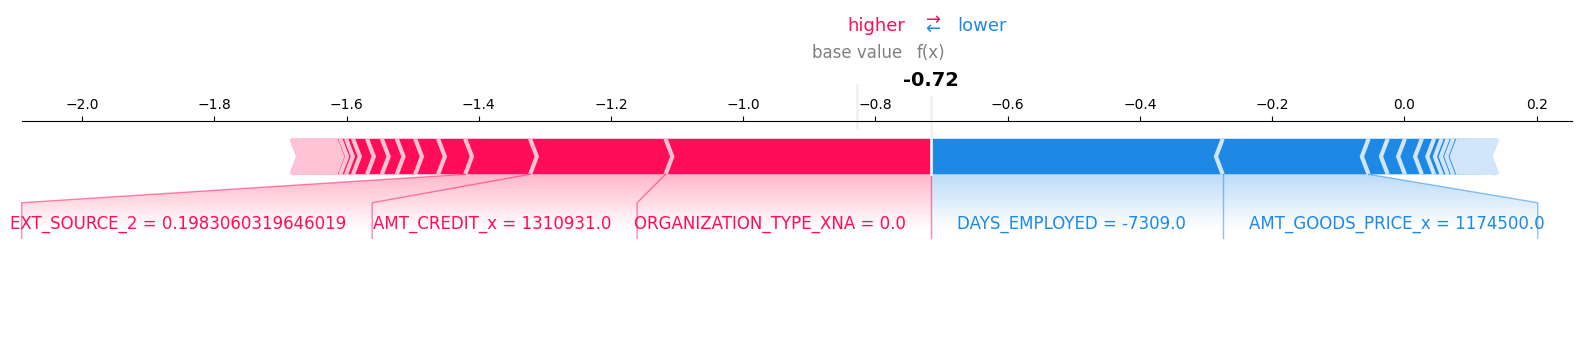

In [99]:
# 2. SHAP force plot (individual prediction explanation)
# Select an instance from validation set for individual explanation
shap.force_plot(explainer.expected_value, shap_values[0].values, X_valid_final.iloc[0,:], matplotlib=True)
